In [1]:
import numpy as np
import torch

In [46]:
n=int(5e4)
N=2
d=100
k=1
radii = [1] * N

In [47]:
func=[lambda x, i=i: torch.sin((i+1)*x) for i in range(d)]
x=torch.rand((int(1e4),))
def apply_on_tensor(functions, tensor):
    out = []
    for i in range(tensor.shape[0]):
        out.append(torch.tensor([f(tensor[i]) for f in functions]))
    return torch.stack(out)

In [48]:
data = apply_on_tensor(func, x)

In [49]:
data.shape

torch.Size([10000, 100])

In [3]:
def sample_sphere(n_samples, manifold_dim, std=-1):

    def polar_to_cartesian(angles):
        xs = []
        sin_prod=1
        for i in range(len(angles)):
            x_i = sin_prod * torch.cos(angles[i])
            xs.append(x_i)
            sin_prod *= torch.sin(angles[i])
        xs.append(sin_prod)
        return torch.stack(xs)[None, ...]

    if std == -1:
        new_data = torch.randn((n_samples, manifold_dim+1))
        norms = torch.linalg.norm(new_data, dim=1)
        new_data = new_data / norms[:,None]
        return new_data
    else:
        sampled_angles = std * torch.randn((n_samples,manifold_dim))
        return torch.cat([polar_to_cartesian(angles) for angles in sampled_angles], dim=0)    


In [4]:
sample_sphere(100,10, std=0.1).shape

torch.Size([100, 11])

In [5]:
def sample_sphere(n_samples, manifold_dim, std=-1):

    def polar_to_cartesian(angles):
        xs = []
        sin_prod=1
        for i in range(len(angles)):
            x_i = sin_prod * torch.cos(angles[i])
            xs.append(x_i)
            sin_prod *= torch.sin(angles[i])
        xs.append(sin_prod)
        return torch.stack(xs)[None, ...]

    if std == -1:
        new_data = torch.randn((n_samples, manifold_dim+1))
        norms = torch.linalg.norm(new_data, dim=1)
        new_data = new_data / norms[:,None]
        return new_data
    else:
        sampled_angles = std * torch.randn((n_samples,manifold_dim))
        return torch.cat([polar_to_cartesian(angles) for angles in sampled_angles], dim=0)    

def generate_data(n_samples, n_spheres, ambient_dim, 
                        manifold_dim, noise_std, embedding_type,
                        radii, angle_std=-1):
            data = []
            for i in range(n_spheres):
                    new_data = sample_sphere(n_samples, manifold_dim, angle_std)
                    new_data = new_data * radii[i]

                    if embedding_type == 'random_isometry':
                        # random isometric embedding
                        embedding_matrix = torch.randn((ambient_dim, manifold_dim+1))
                        q, r = np.linalg.qr(embedding_matrix)
                        q = torch.from_numpy(q)
                        new_data = (q @ new_data.T).T
                    elif embedding_type == 'first':
                        # embedding into first manifold_dim + 1 dimensions
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)
                    elif embedding_type == 'separating':
                        # embbedding which puts spheres in non-intersecting dimensions
                        if n_spheres * (manifold_dim + 1) > ambient_dim:
                            raise RuntimeError('Cant fit that many spheres. Enusre that n_spheres * (manifold_dim + 1) <= ambient_dim')
                        prefix_zeros = torch.zeros((n_samples, i * (manifold_dim + 1)))
                        new_data = torch.cat([prefix_zeros, new_data], dim=1)
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)
                    elif embedding_type == 'along_axis':
                        # embbedding which puts spheres in non-intersecting dimensions
                        if (n_spheres - 1) + (manifold_dim + 1) > ambient_dim:
                            raise RuntimeError('Cant fit that many spheres.')
                        prefix_zeros = torch.zeros((n_samples, i))
                        new_data = torch.cat([prefix_zeros, new_data], dim=1)
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)    
                    else:
                        raise RuntimeError('Unknown embedding type.')
                        
                    # add noise
                    new_data = new_data + noise_std * torch.randn_like(new_data)
                    data.append(new_data)

            data = torch.cat(data, dim=0)
            return data

In [6]:
data = generate_data(n, N, d, k, 0, 'along_axis', radii, 0.5)

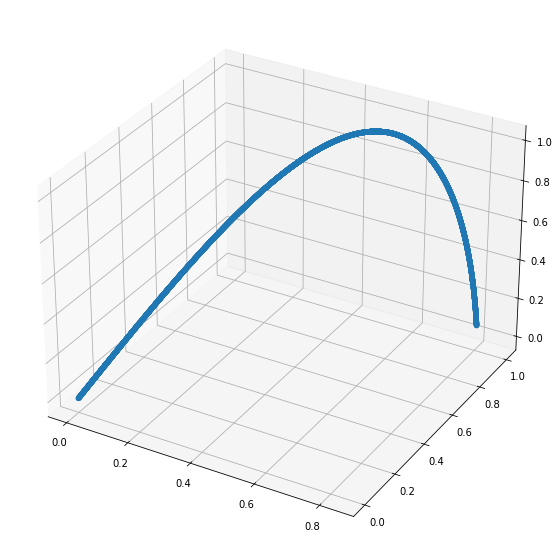

In [51]:
from matplotlib import pyplot as plt
plt_data = data.numpy()
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection='3d'))
ax.scatter(plt_data[:,0], plt_data[:,1], plt_data[:,2])
fig.show()

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components='mle')
pca.fit(data.numpy())
pca.n_components_

98

In [28]:
print(np.linalg.norm(plt_data, axis=1).mean().item())
print(np.linalg.norm(plt_data, axis=1).min().item())
print(np.linalg.norm(plt_data, axis=1).max().item())

1.0
0.9999998211860657
1.0000001192092896


In [41]:
data

tensor([[-0.9523, -0.3051,  0.0000],
        [-0.0862,  0.9963,  0.0000],
        [ 0.7963,  0.6048,  0.0000],
        ...,
        [ 0.0000, -0.1646, -0.9864],
        [ 0.0000,  0.6309, -0.7759],
        [ 0.0000, -0.4252, -0.9051]])

In [43]:
import pickle
with open('logs/ksphere/dim_10/n_2/non_uniform_1/config.pkl', 'rb') as f:
    config = pickle.load(f)

In [46]:
config.data.angle_std

1